# Import libraries & set options

In [22]:
import os
import sys

import numpy as np 
import pandas as pd 

from datetime import datetime, date
import time

import json
from pandas.io.json import json_normalize

import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.metrics import mean_squared_error

import re

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Load train / test

In [4]:
def load_df(csv_path='train.csv', usecols=None, nrows=None):
    #JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    JSON_COLUMNS = ['totals']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     usecols=usecols,
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [5]:
%%time
train_df = load_df(csv_path='input/train_v2.csv', usecols=['fullVisitorId', 'date', 'totals'])
test_df = load_df(csv_path='input/test_v2.csv', usecols=['fullVisitorId', 'date', 'totals'])

Loaded train_v2.csv. Shape: (1708337, 12)
CPU times: user 1min 37s, sys: 17.3 s, total: 1min 55s
Wall time: 2min 48s


Concatenate trains and test

In [14]:
train_df['date'] = train_df['date'].astype('str') 
test_df['date'] = test_df['date'].astype('str') 

df = pd.concat([train_df, test_df])

And preprocess a bit

In [16]:
df = df.fillna(0)
df['totals.totalTransactionRevenue'] = df['totals.totalTransactionRevenue'].fillna(0).astype(float) 
df['date'] = pd.to_datetime(df["date"], format='%Y%m%d')

In [18]:
df = df[['date', 'fullVisitorId', 'totals.totalTransactionRevenue']]

In [19]:
df.head()

,date,fullVisitorId,totals.totalTransactionRevenue
0,2017-10-16,3162355547410993243,0.0
1,2017-10-16,8934116514970143966,0.0
2,2017-10-16,7992466427990357681,0.0
3,2017-10-16,9075655783635761930,0.0
4,2017-10-16,6960673291025684308,0.0


"You will be asked to predict the same calculation of the natural log of the sum of all transactions for each existing fullVisitorId, but only for the existing visitors from August 1, 2016 to October 15, 2018".

In [21]:
df['date'].min(), df['date'].max()

(Timestamp('2016-08-01 00:00:00'), Timestamp('2018-10-15 00:00:00'))

Calculate total revenue for each user and select only users with positive amount


In [31]:
agg_rev_per_user = df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum().reset_index()

guys_with_pos_rev = agg_rev_per_user[agg_rev_per_user['totals.totalTransactionRevenue'] > 0.0]
guys_with_pos_rev_full = df[df['fullVisitorId'].isin(guys_with_pos_rev['fullVisitorId'])]

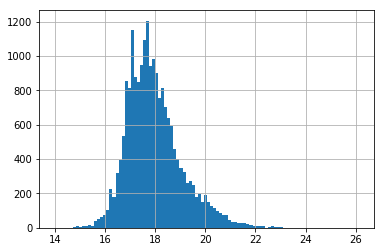

In [30]:
np.log1p(guys_with_pos_rev['totals.totalTransactionRevenue']).hist(bins=100);

# Time-series processing

## Initial time-series

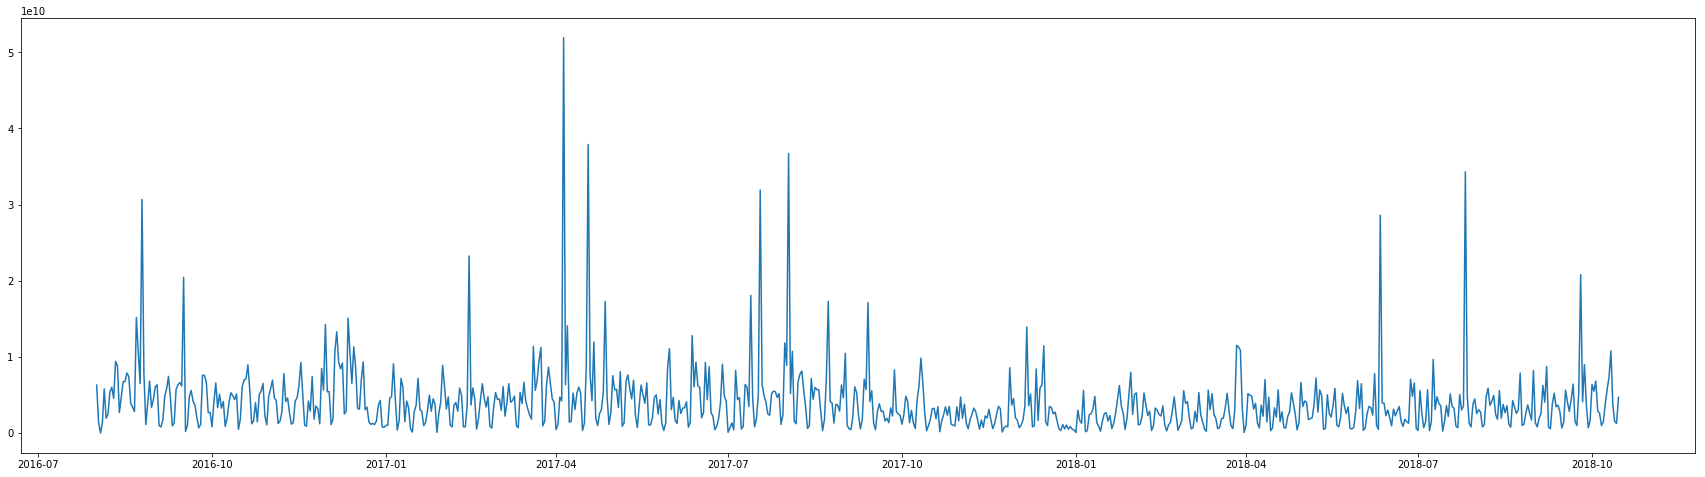

In [50]:
ts = guys_with_pos_rev_full.groupby('date')['totals.totalTransactionRevenue'].sum().reset_index()

plt.figure(figsize=(30,8))
plt.plot(ts['date'], ts['totals.totalTransactionRevenue']);

## Reject outliers

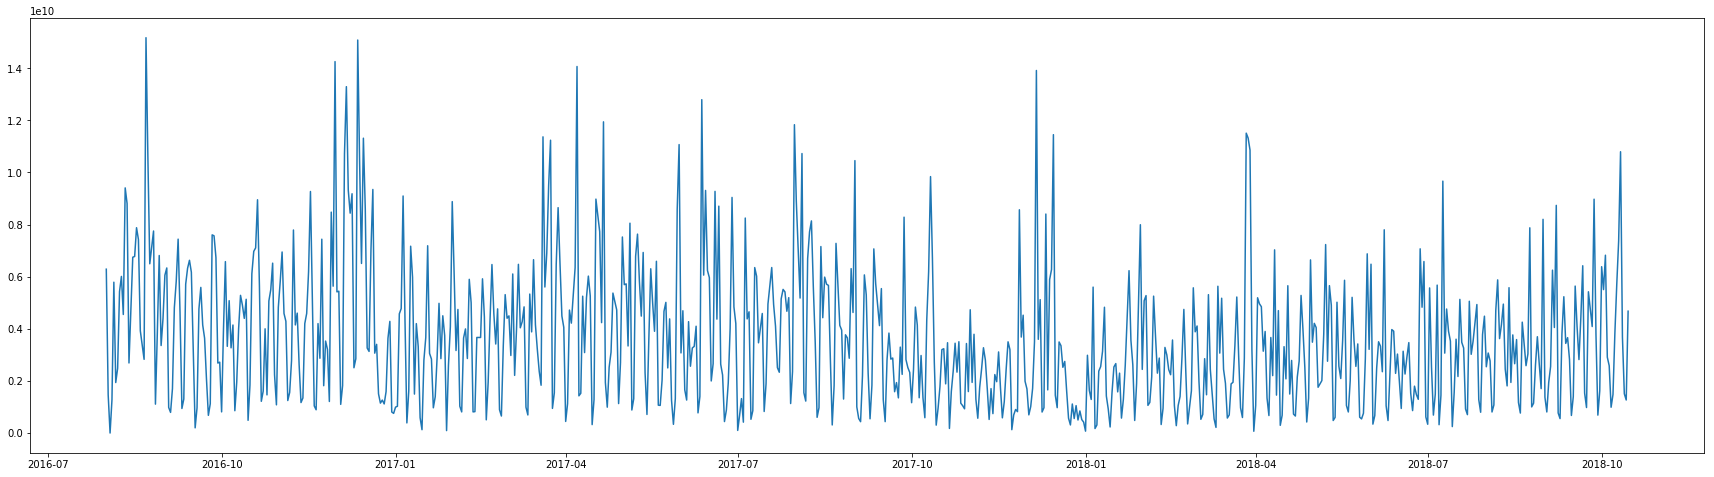

In [51]:
def reject_outliers(data, m=2):
    return [e if (abs(e - np.mean(data)) < m * np.std(data)) else np.nan for e in data]

ts['totals.totalTransactionRevenue'] = reject_outliers(ts['totals.totalTransactionRevenue'], m=3)
ts = ts.dropna()

plt.figure(figsize=(30,8))
plt.plot(ts['date'], ts['totals.totalTransactionRevenue']);

##  Smoothing

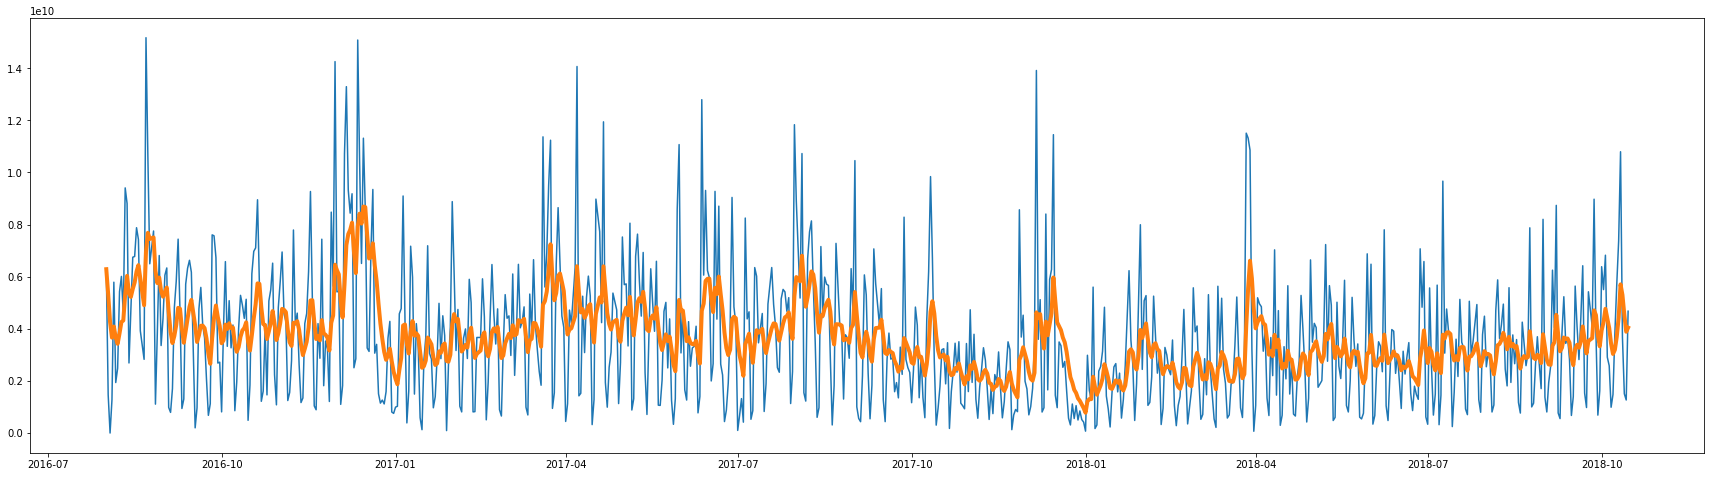

In [52]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

ts['smoothed'] = exponential_smoothing(ts['totals.totalTransactionRevenue'].values, alpha=0.2)

plt.figure(figsize=(30,8))
plt.plot(ts['date'], ts['totals.totalTransactionRevenue']);
plt.plot(ts['date'], ts['smoothed'], linewidth=4);

## Prediction (not rly)

In [53]:
from fbprophet import Prophet

m = Prophet(
    n_changepoints=25, 
    yearly_seasonality=True, 
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_prior_scale=10.0
)
m.fit(ts[['date', 'smoothed']].rename(columns={'smoothed': 'y', 'date': 'ds'}))

pred = m.predict()[['ds', 'yhat']]

In [54]:
future = m.make_future_dataframe(periods=300)
forecast = m.predict(future)

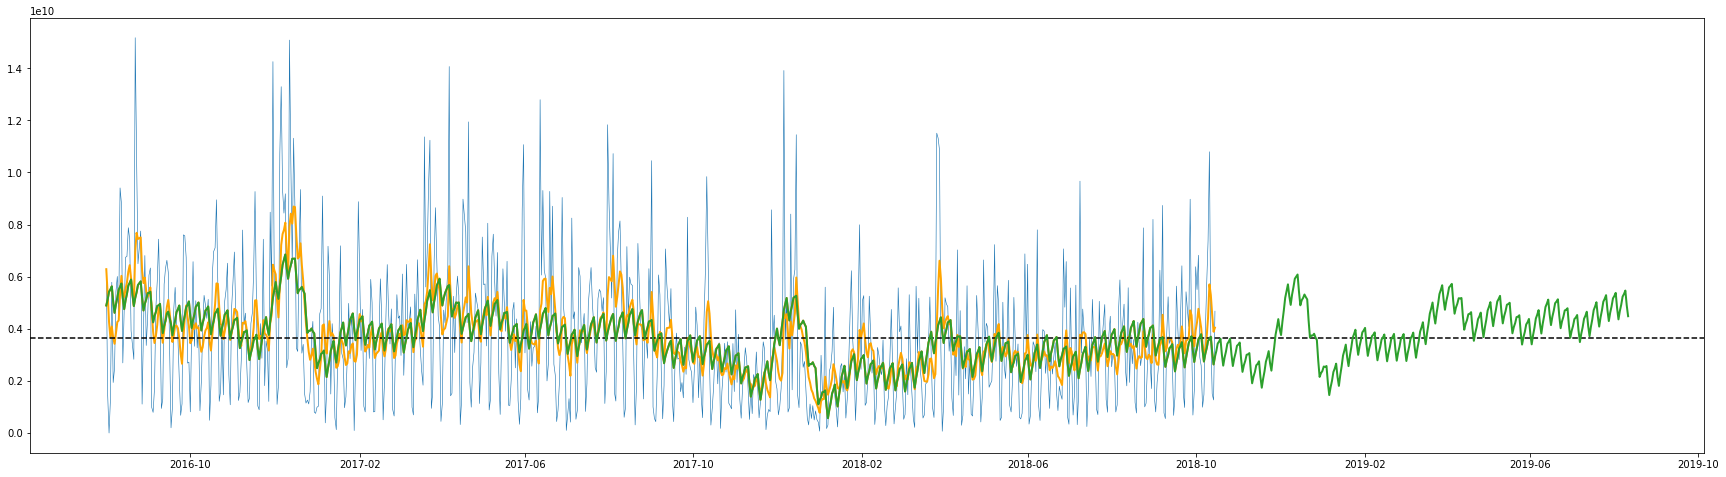

In [55]:
plt.figure(figsize=(30,8))
plt.plot(ts['date'], ts['totals.totalTransactionRevenue'], linewidth=0.6);
plt.plot(ts['date'], ts['smoothed'], linewidth=2, color='orange');

plt.plot(pred['ds'], pred['yhat'], linewidth=2);
plt.axhline(ts['smoothed'].mean(), linestyle='--', color='k')
plt.plot(forecast['ds'], forecast['yhat'], linewidth=2);

## Log transformation -> prediction

In [56]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

y_box, lmbda = boxcox(ts['totals.totalTransactionRevenue'].values + 1)
print(f'Box-Cox lambda {lmbda}')
ts['smoothed_boxcox'] = y_box

Box-Cox lambda 0.3518137664535156


In [57]:
m = Prophet(
    n_changepoints=25, 
    yearly_seasonality=True, 
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_prior_scale=10.0
)

m.fit(ts[['date', 'smoothed_boxcox']][10:].rename(columns={'smoothed_boxcox': 'y', 'date': 'ds'}))

future = m.make_future_dataframe(periods=300)
forecast = m.predict(future)

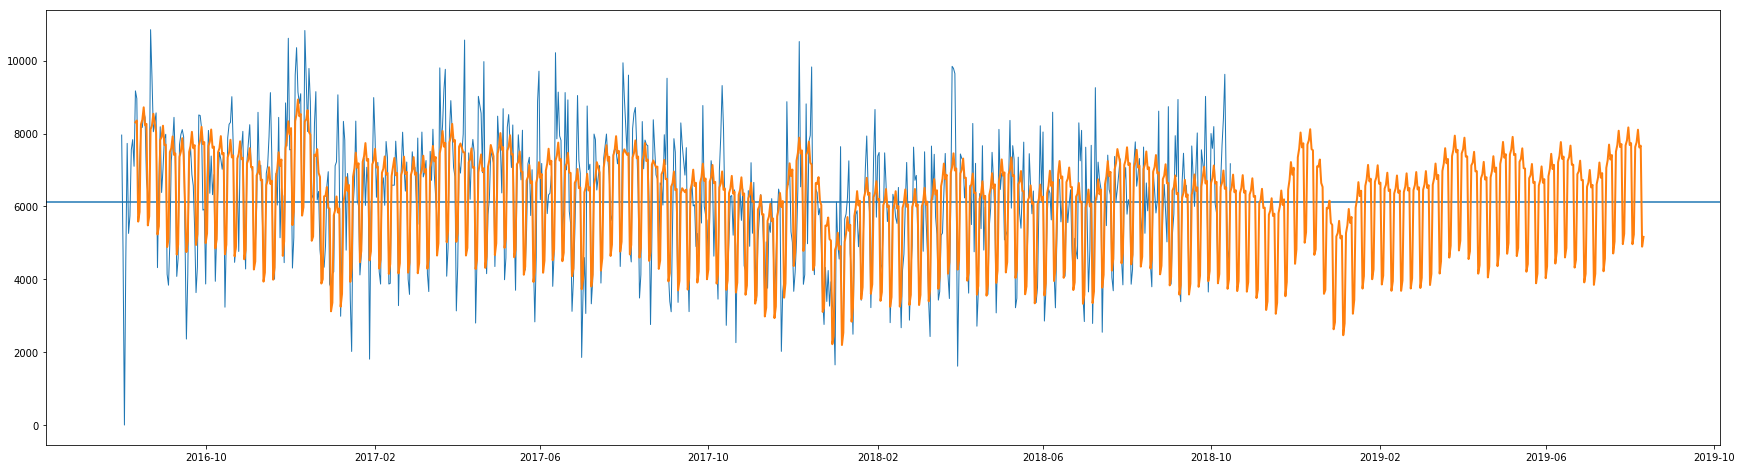

In [58]:
plt.figure(figsize=(30,8))
plt.plot(ts['date'], ts['smoothed_boxcox'], linewidth=1);
plt.axhline(ts['smoothed_boxcox'].mean())
plt.plot(forecast['ds'], forecast['yhat'], linewidth=2);

"The test set will be future-looking, composed of **all transactions from December 1, 2018 through January 31, 2019**. You will be asked to predict the same calculation of the **natural log of the sum of all transactions for each existing fullVisitorId, but only for the existing visitors from August 1, 2016 to October 15, 2018**".

In [59]:
forecast_boxcox_test = forecast[(forecast['ds'] >= '2018-12-01') & ((forecast['ds'] <= '2019-01-31'))]
forecast_test = inv_boxcox(forecast_boxcox_test['yhat'], lmbda)

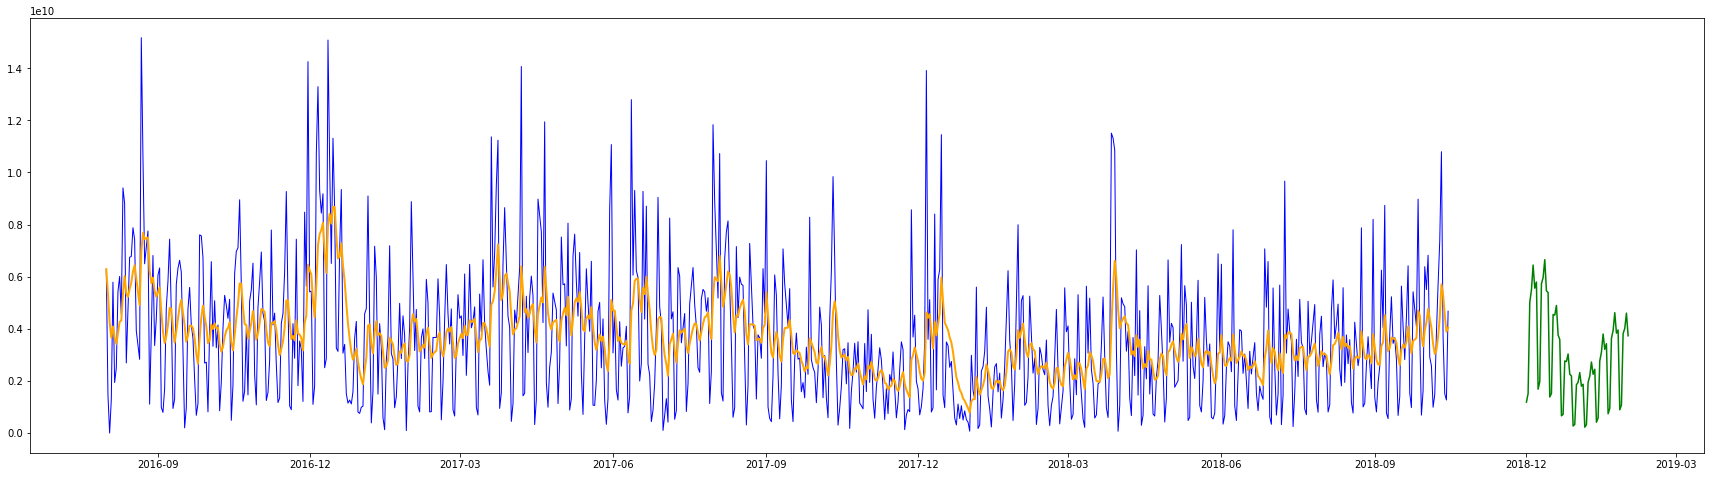

In [60]:
plt.figure(figsize=(30,8))
plt.plot(ts['date'], ts['totals.totalTransactionRevenue'], linewidth=1, color='blue');
plt.plot(ts['date'], ts['smoothed'], linewidth=2, color='orange');
plt.plot(forecast_boxcox_test['ds'], forecast_test, color='g');

# Distribute sum among all users 

In [61]:
forecast_sum = forecast_test.sum()
forecast_sum

182057260729.1923

In [62]:
distr = (df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum() / 
         df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum().sum())

In [64]:
distr.head()

fullVisitorId
0000000259678714014    0.0
0000010278554503158    0.0
0000018966949534117    0.0
0000020424342248747    0.0
0000027376579751715    0.0
Name: totals.totalTransactionRevenue, dtype: float64

In [65]:
df_users = df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum().reset_index()

In [75]:
scale_koef = (df_users['totals.totalTransactionRevenue'] > 0).sum() / len(df_users)
# scale_koef = 1.0
distr_res = np.log1p(distr * forecast_sum * scale_koef)

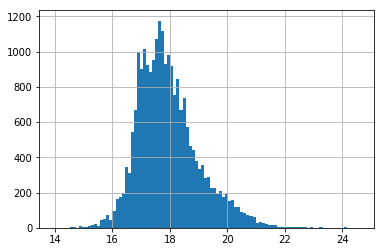

In [76]:
np.log1p(df[df['totals.totalTransactionRevenue'] > 0]['totals.totalTransactionRevenue']).hist(bins=100);

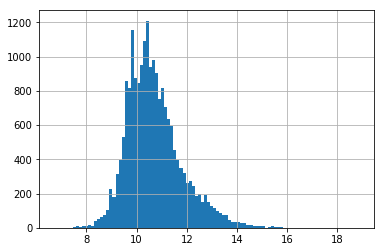

In [77]:
distr_res[distr_res > 0].hist(bins=100);

# Save result

In [81]:
sample_subm = pd.read_csv('input/sample_submission_v2.csv', dtype={'fullVisitorId': 'str'}, )
solution = sample_subm.merge(distr_res.reset_index(), on='fullVisitorId', how='left')
solution = (
    solution
    .drop('PredictedLogRevenue', axis=1)
    .rename(columns={'totals.totalTransactionRevenue': 'PredictedLogRevenue'})
)

solution.to_csv('model_1.csv', index=False, float_format='%.6f')